# Benchmark

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import NeSI.data

sb.set()

In [2]:
jobs = [
    30961630,  # 2 PCIe A100 (1 node)
    30982571,  # 2 PCIe A100 (1 node)
    30975009,  # 2 PCIe A100 (2 nodes)
    30975012,  # 4 PCIe A100 (2 nodes)
    31571966,  # 4 HGX A100 (1 node)
    31571995,  # 2 HGX A100 (1 node)
    31795928,  # 4 HGX A100 (2 node)
    31803550,  # 8 HGX A100 (2 node)
]

In [3]:
dset = []

for jobid in jobs:
    dset_job = NeSI.data.datalake.query(
        f"""
        select
            jobid,
            elapsed,
            partition,
            allocnodes,
            allocgpus,
            typegpu,
            state
        from slurm_jobs.finished_job_data
        where jobid like '{jobid}%%'
        """
    )
    dset.append(dset_job)

dset = pd.concat(dset)

In [4]:
dset

,jobid,elapsed,partition,allocnodes,allocgpus,typegpu,state
0,30961630,35465,gpu,1,2,A100,COMPLETED
0,30982571,37914,gpu,1,2,A100,COMPLETED
0,30975009,34643,gpu,2,2,A100,COMPLETED
0,30975012,21069,gpu,2,4,A100,COMPLETED
0,31571966_0,16299,hgx,1,4,A100,COMPLETED
1,31571966_1,16331,hgx,1,4,A100,COMPLETED
2,31571966_2,16130,hgx,1,4,A100,COMPLETED
3,31571966_3,16148,hgx,1,4,A100,COMPLETED
4,31571966_4,16012,hgx,1,4,A100,COMPLETED
0,31571995_0,27630,hgx,1,2,A100,COMPLETED


In [5]:
def format_case(x):
    gpu_type = "PCIe" if x.partition == "gpu" else "HGX"
    return f"{x.allocgpus} {gpu_type} {x.typegpu} ({x.allocnodes} nodes)"


dset["testcase"] = dset.apply(format_case, axis=1)
dset["duration (hours)"] = dset["elapsed"] / 3600

In [6]:
idx = (
    dset[dset.state == "COMPLETED"]
    .groupby("testcase")["duration (hours)"]
    .mean()
    .sort_values(ascending=False)
    .index
)

<AxesSubplot:xlabel='testcase', ylabel='duration (hours)'>

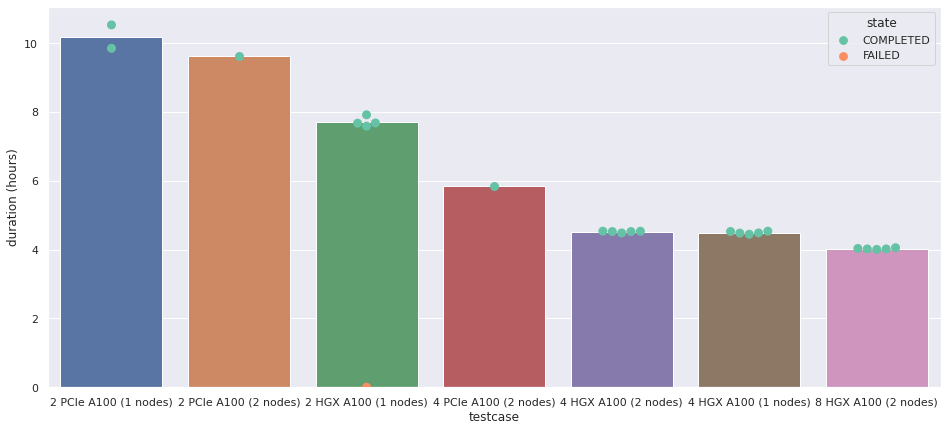

In [7]:
_, ax = plt.subplots(figsize=(16, 7))
sb.barplot(
    data=dset[dset.state == "COMPLETED"],
    x="testcase",
    y="duration (hours)",
    ax=ax,
    ci=0,
    order=idx,
)
sb.swarmplot(
    data=dset,
    x="testcase",
    y="duration (hours)",
    hue="state",
    ax=ax,
    s=9,
    palette="Set2",
    order=idx,
)